In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

/Users/thilina/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
file_path = "data/MWPF_Damping_Scheme_Replacements.csv"
df_crude = pd.read_csv(file_path)
df_crude

,date,Crude_oil_price
0,2001-01-02,27.290000
1,2001-01-03,27.930000
2,2001-01-04,27.950000
3,2001-01-05,28.020000
4,2001-01-06,27.440000
...,...,...
8312,2023-10-06,71.466572
8313,2023-10-07,85.890000
8314,2023-10-08,85.890000
8315,2023-10-09,85.890000


In [3]:
df_crude_index = df_crude.set_index('date')
df_crude_index

,Crude_oil_price
date,
2001-01-02,27.290000
2001-01-03,27.930000
2001-01-04,27.950000
2001-01-05,28.020000
2001-01-06,27.440000
...,...
2023-10-06,71.466572
2023-10-07,85.890000
2023-10-08,85.890000


<Axes: xlabel='date'>

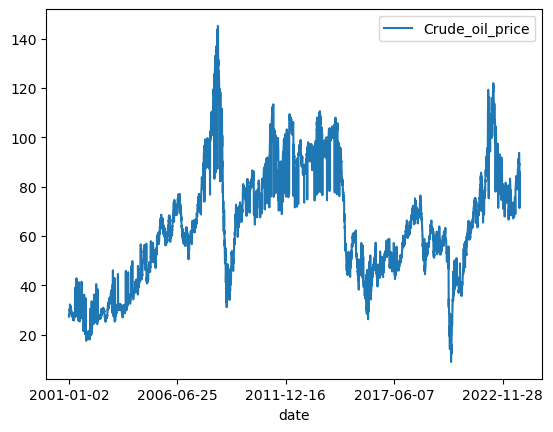

In [4]:
data = df_crude_index
data['Crude_oil_price'].plot(legend=True)

In [5]:
# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)
training_data_len

#Splitting the dataset
train_data = data[:training_data_len].iloc[:,:1]
test_data = data[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6654, 1) (1663, 1)


In [6]:
train_data

,Crude_oil_price
date,
2001-01-02,27.29
2001-01-03,27.93
2001-01-04,27.95
2001-01-05,28.02
2001-01-06,27.44
...,...
2019-03-18,59.09
2019-03-19,59.12
2019-03-20,60.12


In [7]:
test_data

,Crude_oil_price
date,
2019-03-23,58.710000
2019-03-24,58.710000
2019-03-25,58.710000
2019-03-26,59.870000
2019-03-27,59.390000
...,...
2023-10-06,71.466572
2023-10-07,85.890000
2023-10-08,85.890000


In [8]:
# Selecting Crude_oil_price values
dataset_train = train_data.Crude_oil_price.values

# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6654, 1)

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))

# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

[[0.07668808]
 [0.08170139]
 [0.08185806]
 [0.08240639]
 [0.07786307]]


In [10]:
# Selecting Open Price values
dataset_test = test_data.Crude_oil_price.values

# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[0.44059099] [0.44059099] [0.44059099] [0.45085376] [0.4466071]


In [11]:
X_train = []
y_train = []
for i in range(100, len(scaled_train)):
    X_train.append(scaled_train[i-100:i, 0])
    y_train.append(scaled_train[i, 0])
    if i <= 101:
        print(X_train)
        print(y_train)
        print()

[array([0.07668808, 0.08170139, 0.08185806, 0.08240639, 0.07786307,
       0.07786307, 0.07786307, 0.0800564 , 0.09337302, 0.09337302,
       0.09846467, 0.09940467, 0.09940467, 0.09940467, 0.09940467,
       0.09611468, 0.10120633, 0.11452295, 0.11522795, 0.11522795,
       0.11522795, 0.11091963, 0.10935297, 0.11052796, 0.09627135,
       0.09063136, 0.09063136, 0.09063136, 0.09102303, 0.08710638,
       0.09697634, 0.10786464, 0.10222466, 0.10222466, 0.10222466,
       0.10003133, 0.10786464, 0.11021463, 0.10520132, 0.10198966,
       0.10198966, 0.10198966, 0.09885634, 0.09439135, 0.0897697 ,
       0.09180636, 0.08694971, 0.08694971, 0.08694971, 0.08694971,
       0.08726304, 0.08632305, 0.08875137, 0.08436472, 0.08436472,
       0.08436472, 0.08428639, 0.07715808, 0.0805264 , 0.08138806,
       0.08702804, 0.08702804, 0.08702804, 0.08538305, 0.08969137,
       0.08467805, 0.08201473, 0.08154473, 0.08154473, 0.08154473,
       0.07794141, 0.07042143, 0.07096976, 0.07190976, 0.0679

In [12]:
X_test = []
y_test = []
for i in range(100, len(scaled_test)):
    X_test.append(scaled_test[i-100:i, 0])
    y_test.append(scaled_test[i, 0])

In [13]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (6554, 100, 1) y_train : (6554, 1)


In [14]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_test : (1563, 100, 1) y_test : (1563, 1)


### **RNN**

In [15]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 5, batch_size=32, validation_split=0.2)
regressor.summary()

Epoch 1/5
164/164 [==============================] - 8s 44ms/step - loss: 0.0067 - val_loss: 0.0013
Epoch 2/5
164/164 [==============================] - 7s 44ms/step - loss: 0.0023 - val_loss: 6.7168e-04
Epoch 3/5
164/164 [==============================] - 7s 44ms/step - loss: 0.0019 - val_loss: 5.1930e-04
Epoch 4/5
164/164 [==============================] - 7s 44ms/step - loss: 0.0017 - val_loss: 6.4199e-04
Epoch 5/5
164/164 [==============================] - 7s 44ms/step - loss: 0.0016 - val_loss: 4.7525e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 50)           2600      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 50)           5050      
  

### **LSTM**

In [16]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(50, return_sequences=False))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(Dense(25))

# Adding the output layer
regressorLSTM.add(Dense(1))

# Compiling the model
regressorLSTM.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model
history = regressorLSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
regressorLSTM.summary()

Epoch 1/10
164/164 [==============================] - 16s 80ms/step - loss: 0.0078 - val_loss: 5.3088e-04
Epoch 2/10
164/164 [==============================] - 13s 78ms/step - loss: 0.0025 - val_loss: 6.1540e-04
Epoch 3/10
164/164 [==============================] - 13s 80ms/step - loss: 0.0020 - val_loss: 4.7645e-04
Epoch 4/10
164/164 [==============================] - 13s 80ms/step - loss: 0.0018 - val_loss: 4.9118e-04
Epoch 5/10
164/164 [==============================] - 13s 79ms/step - loss: 0.0017 - val_loss: 4.3167e-04
Epoch 6/10
164/164 [==============================] - 13s 79ms/step - loss: 0.0015 - val_loss: 4.1001e-04
Epoch 7/10
164/164 [==============================] - 13s 80ms/step - loss: 0.0015 - val_loss: 4.3164e-04
Epoch 8/10
164/164 [==============================] - 13s 79ms/step - loss: 0.0014 - val_loss: 4.5504e-04
Epoch 9/10
164/164 [==============================] - 13s 79ms/step - loss: 0.0014 - val_loss: 5.9291e-04
Epoch 10/10
164/164 [=========================

### **GRU**

In [17]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
                       activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01,
                                   momentum=0.9,
                                   nesterov=False),
                     loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(X_train,y_train,epochs=5, batch_size=32, validation_split=0.2)
regressorGRU.summary()

Epoch 1/5
164/164 [==============================] - 20s 102ms/step - loss: 0.1978 - val_loss: 0.0805
Epoch 2/5
164/164 [==============================] - 17s 102ms/step - loss: 0.1978 - val_loss: 0.0805
Epoch 3/5
164/164 [==============================] - 17s 103ms/step - loss: 0.1978 - val_loss: 0.0805
Epoch 4/5
164/164 [==============================] - 17s 104ms/step - loss: 0.1978 - val_loss: 0.0805
Epoch 5/5
164/164 [==============================] - 17s 103ms/step - loss: 0.1978 - val_loss: 0.0805
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 100, 50)           15300     
      

In [18]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)

49/49 [==============================] - 2s 21ms/step


In [19]:
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)
y_GRU_O = scaler.inverse_transform(y_GRU)

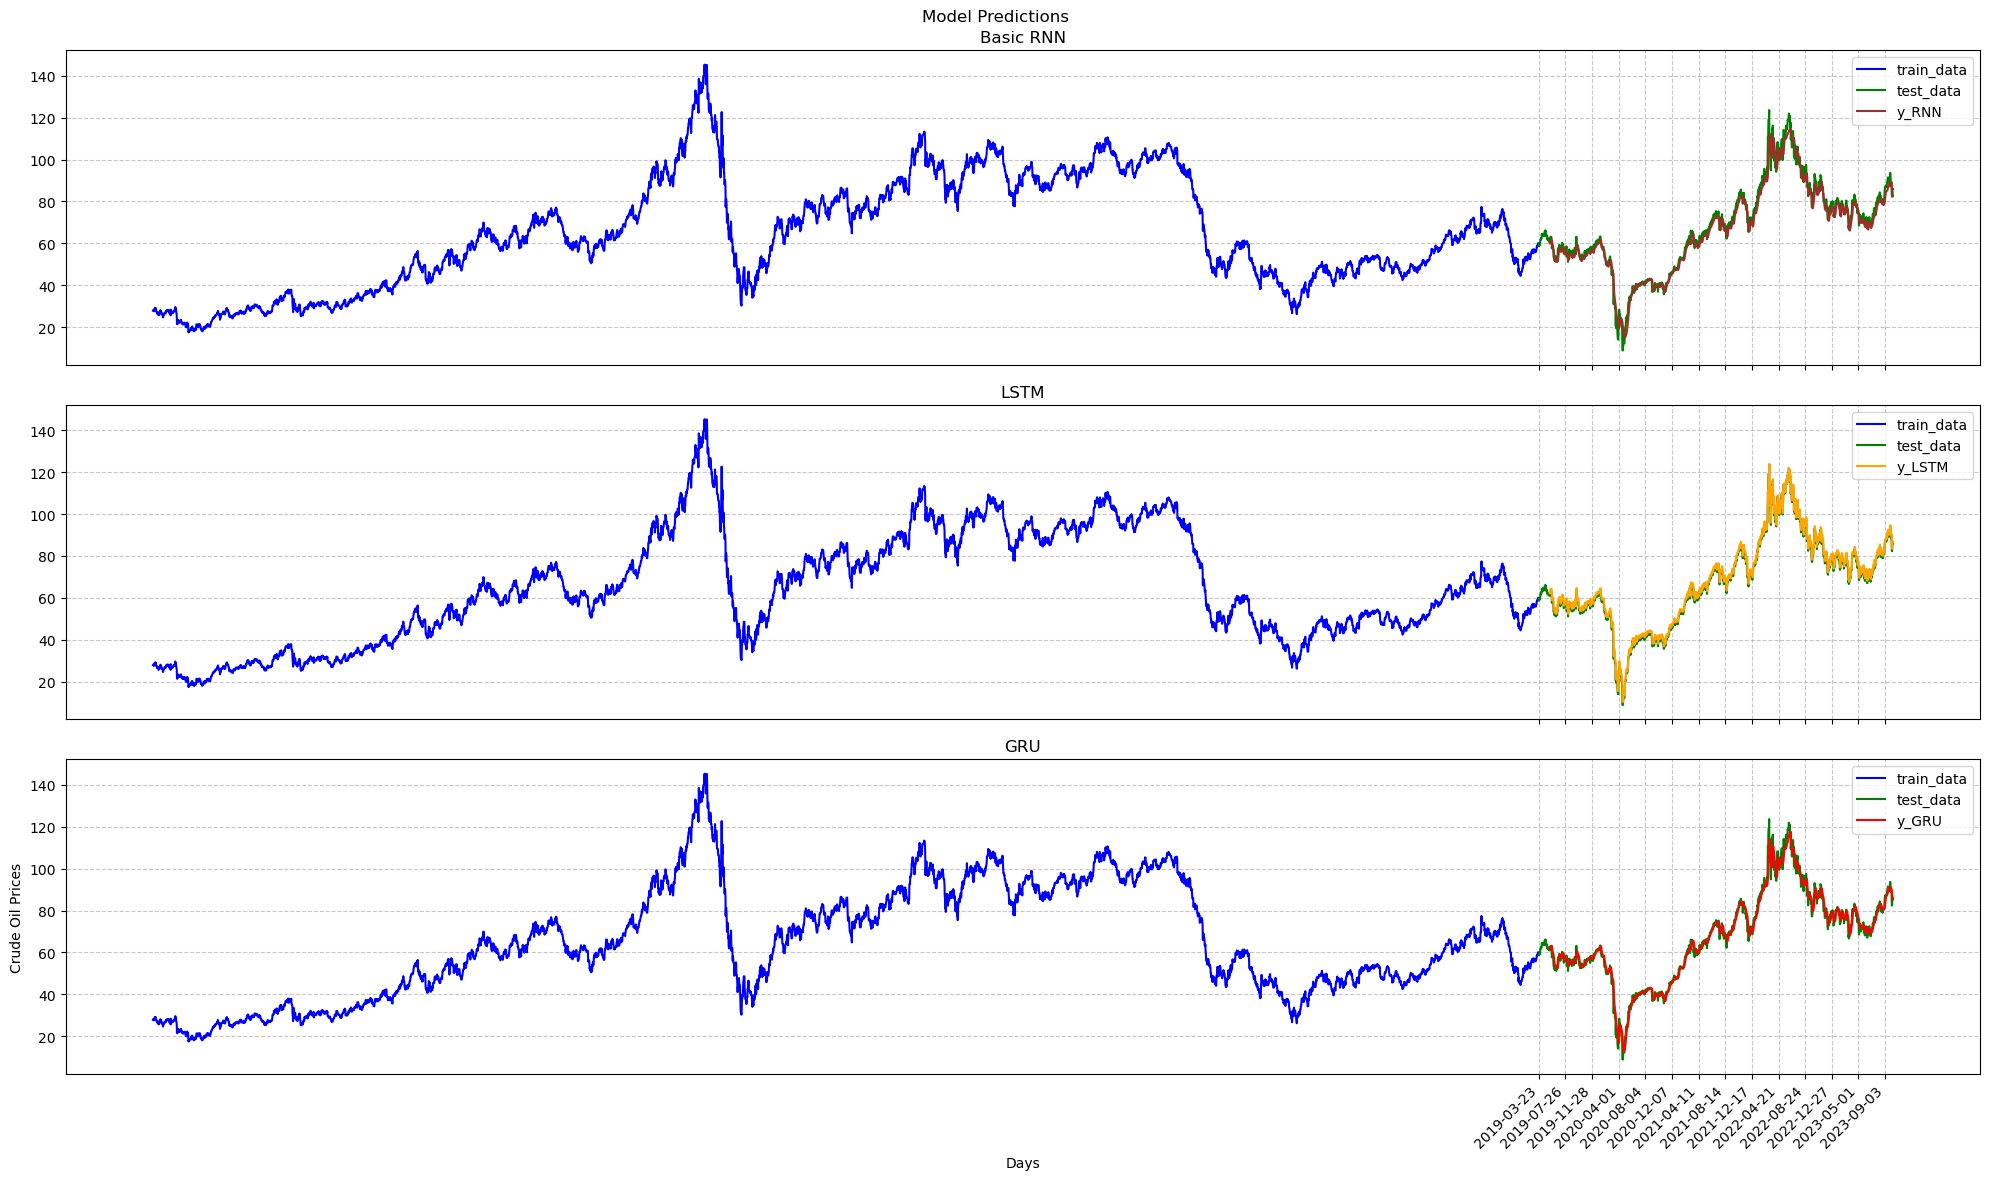

In [26]:
fig, axs = plt.subplots(3,figsize =(20,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.Crude_oil_price[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.Crude_oil_price, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.Crude_oil_price[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.Crude_oil_price, label = "test_data", color = "g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.Crude_oil_price[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.Crude_oil_price, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Crude Oil Prices")

n = 125
for ax in axs:
    ax.set_xticks(test_data.index[::n])
    ax.set_xticklabels(test_data.index[::n], rotation=45, ha="right")

# Add grid lines
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [20]:
# scaling back from 0-1 to original
Y_test_O = scaler.inverse_transform(y_test)

In [21]:
mse_RNN = mean_squared_error(Y_test_O, y_RNN_O)
mse_LSTM = mean_squared_error(Y_test_O, y_LSTM_O)
mse_GRU = mean_squared_error(Y_test_O, y_GRU_O)

print("Mean Squared Error for RNN:", mse_RNN)
print("Mean Squared Error for LSTM:", mse_LSTM)
print("Mean Squared Error for GRU:", mse_GRU)

Mean Squared Error for RNN: 24.10896786146243
Mean Squared Error for LSTM: 14.490083649086758
Mean Squared Error for GRU: 3954.689170389192


In [22]:
rmse_RNN = np.sqrt(mse_RNN)
rmse_LSTM = np.sqrt(mse_LSTM)
rmse_GRU = np.sqrt(mse_GRU)

print("Root Mean Squared Error for RNN:", rmse_RNN)
print("Root Mean Squared Error for LSTM:", rmse_LSTM)
print("Root Mean Squared Error for GRU:", rmse_GRU)

Root Mean Squared Error for RNN: 4.910088376135651
Root Mean Squared Error for LSTM: 3.8065842495716233
Root Mean Squared Error for GRU: 62.8863194215498


#### Prediction for the test set

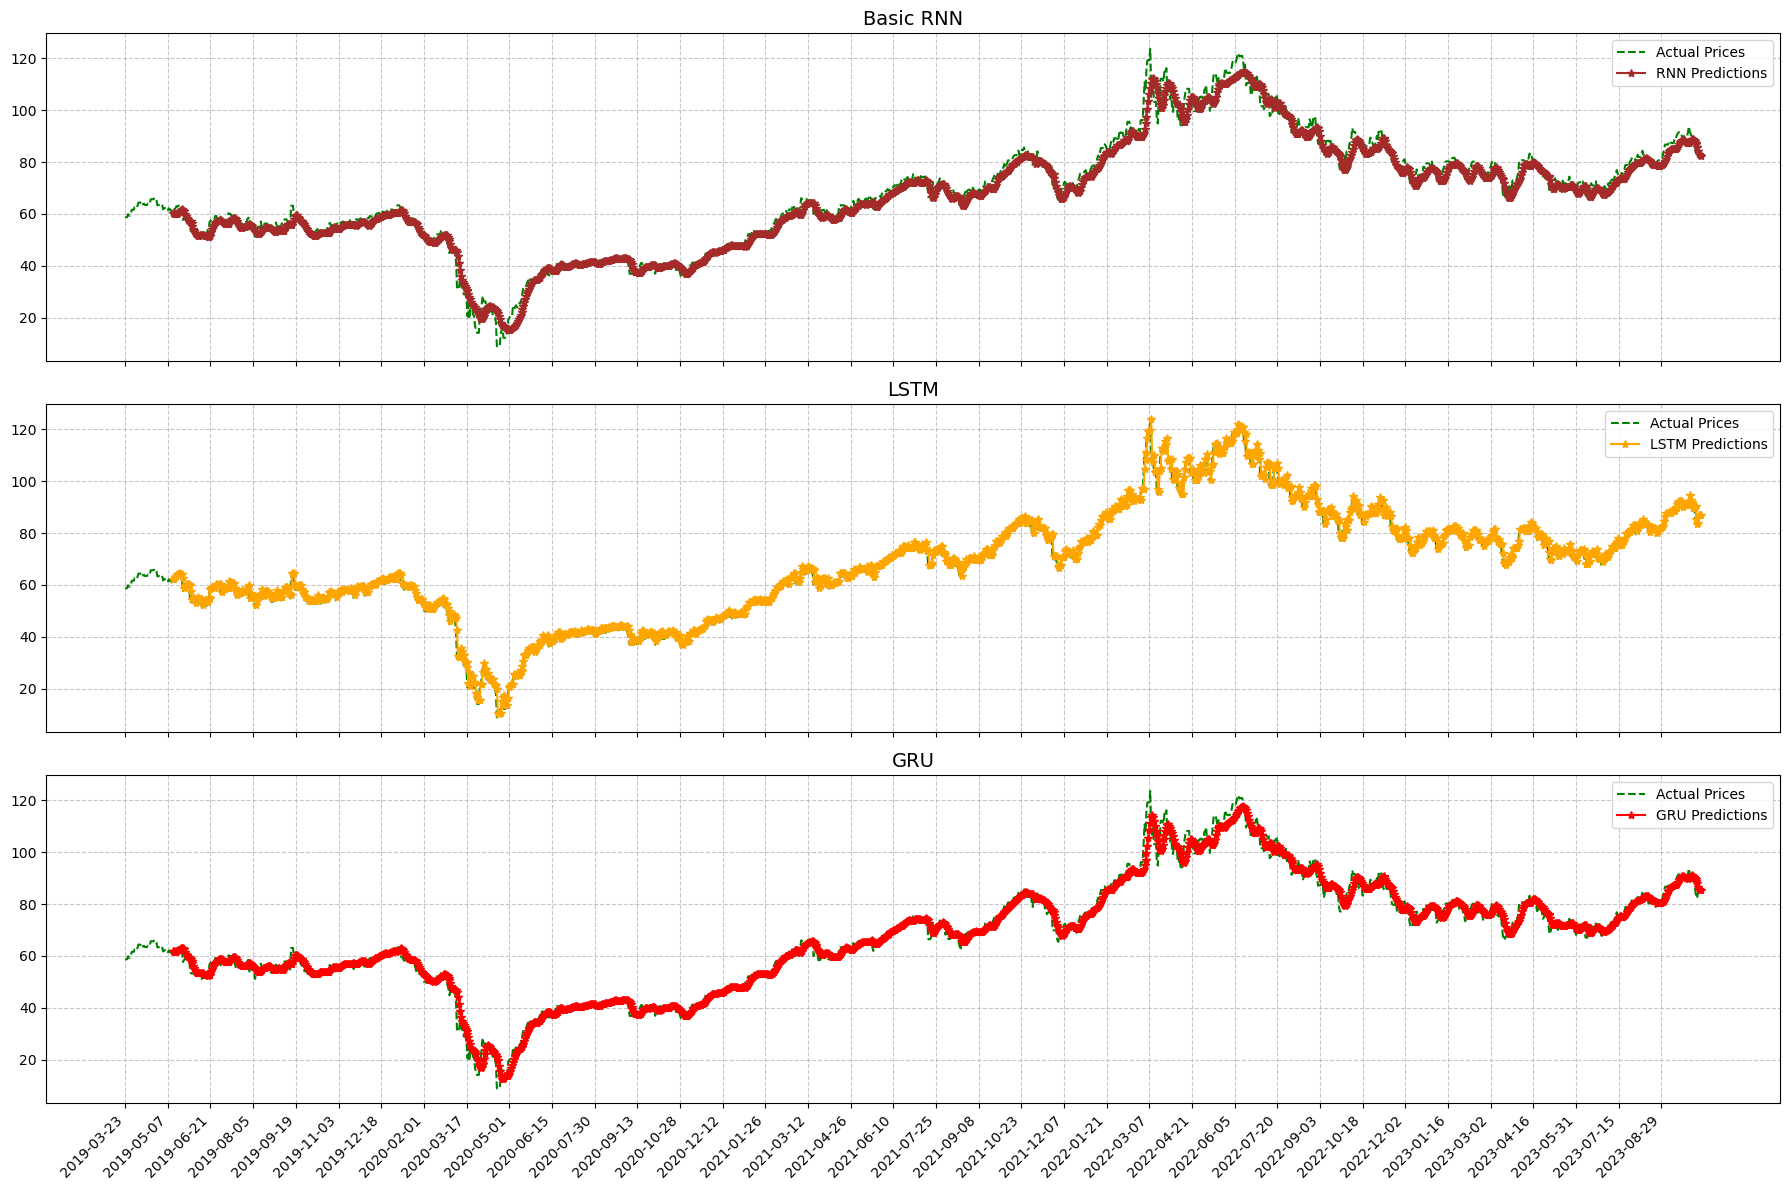

In [24]:
fig, axs = plt.subplots(3, figsize=(18, 12), sharex=True, sharey=True)
# fig.suptitle('Model Predictions', fontsize=16, y=0.95)

# Plot for RNN predictions (last 100 data points)
axs[0].plot(test_data.index, test_data.Crude_oil_price, label="Actual Prices", color="g", linestyle='--')
axs[0].plot(test_data.index[50:], y_RNN_O, label="RNN Predictions", color="brown", marker='*')
axs[0].legend()
axs[0].set_title("Basic RNN", fontsize=14)

# Plot for LSTM predictions (last 100 data points)
axs[1].plot(test_data.index, test_data.Crude_oil_price, label="Actual Prices", color="g", linestyle='--')
axs[1].plot(test_data.index[50:], y_LSTM_O, label="LSTM Predictions", color="orange", marker='*')
axs[1].legend()
axs[1].set_title("LSTM", fontsize=14)

# Plot for GRU predictions (last 100 data points)
axs[2].plot(test_data.index, test_data.Crude_oil_price, label="Actual Prices", color="g", linestyle='--')
axs[2].plot(test_data.index[50:], y_GRU_O, label="GRU Predictions", color="red", marker='*')
axs[2].legend()
axs[2].set_title("GRU", fontsize=14)

# Set common labels
# fig.text(0.5, 0.08, "Days", ha="center", va="center", fontsize=14)
# fig.text(0.08, 0.5, "Crude Oil Prices", ha="center", va="center", rotation="vertical", fontsize=14)

# Customize x-axis ticks (show every 5th date for example)
n = 45
for ax in axs:
    ax.set_xticks(test_data.index[::n])
    ax.set_xticklabels(test_data.index[::n], rotation=45, ha="right")

# Add grid lines
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### Predictions for last 100 days

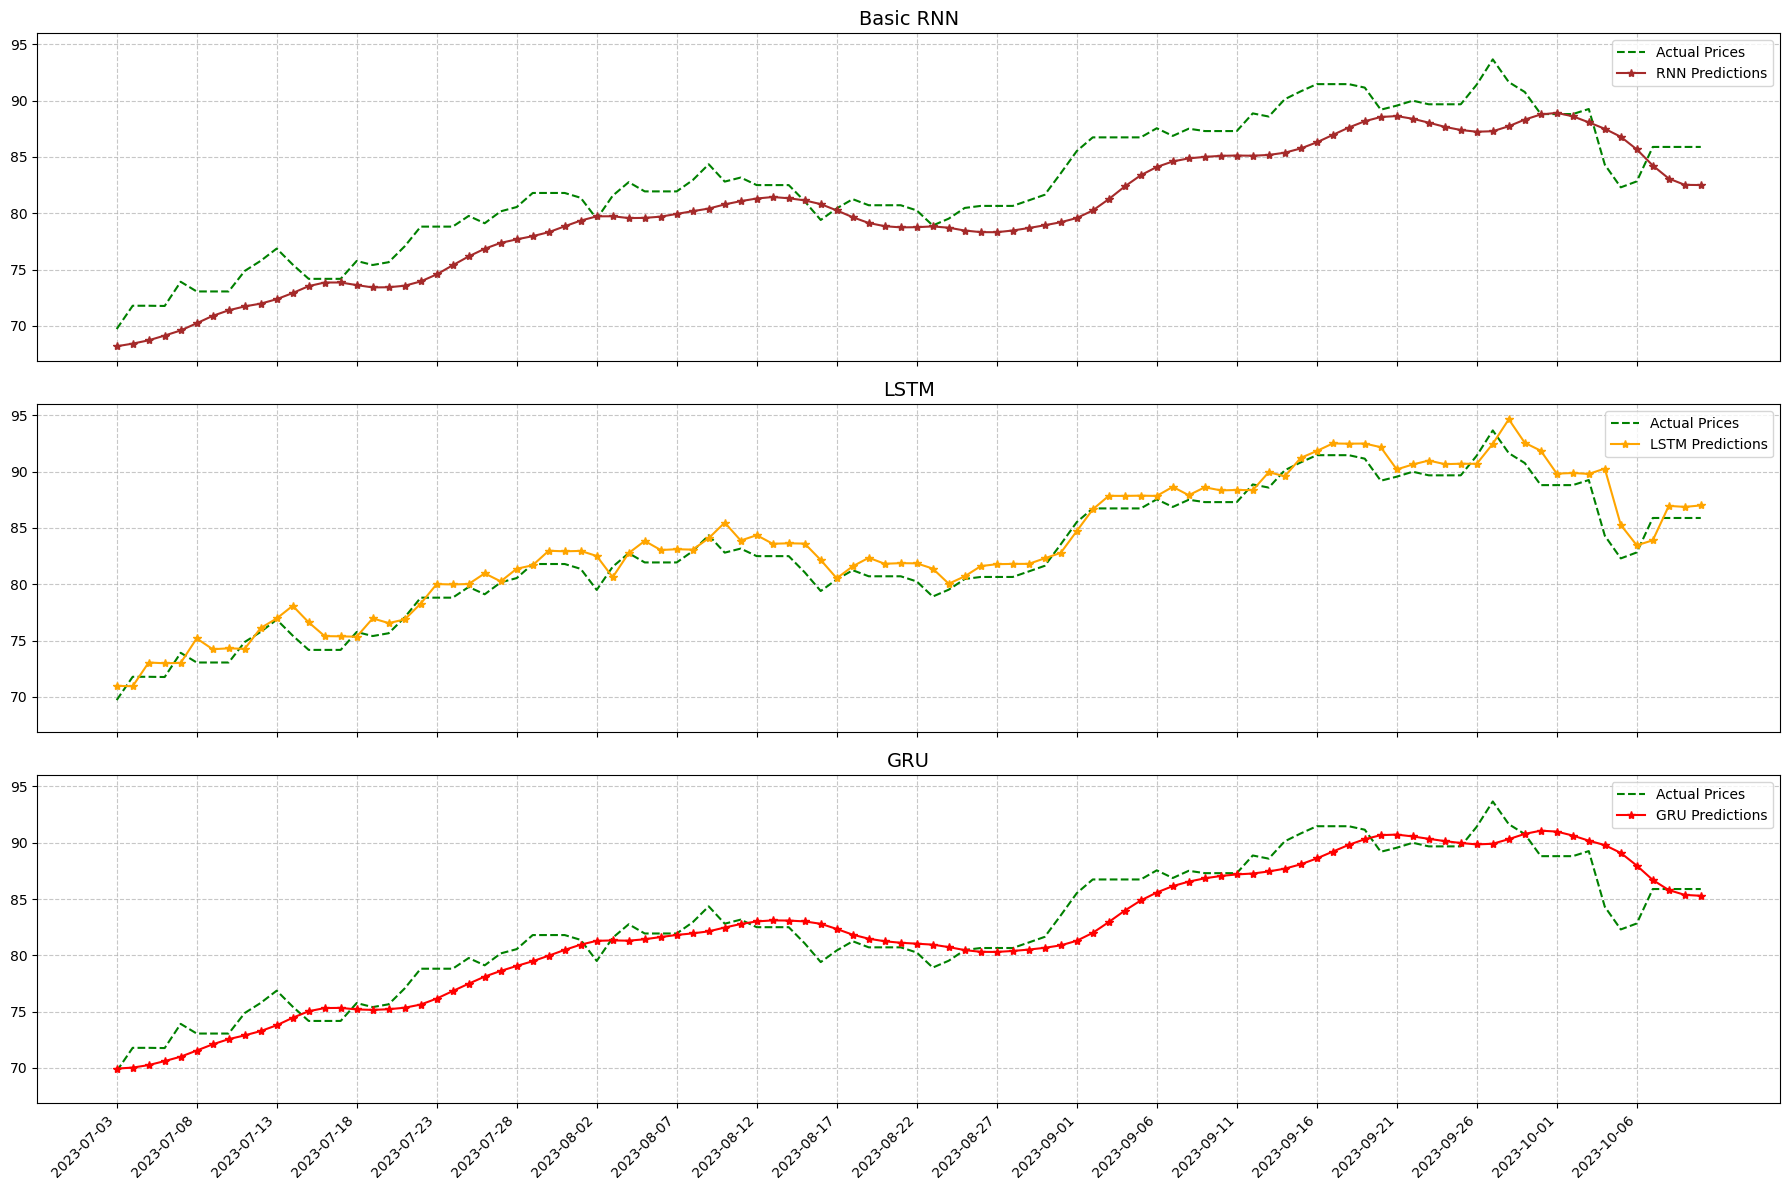

In [25]:
# Extract the last 100 dates from the test set
last_100_dates = test_data.index[-100:]

fig, axs = plt.subplots(3, figsize=(18, 12), sharex=True, sharey=True)
# fig.suptitle('Model Predictions', fontsize=16, y=0.95)

# Plot for RNN predictions (last 100 data points)
axs[0].plot(last_100_dates, test_data.Crude_oil_price[-100:], label="Actual Prices", color="g", linestyle='--')
axs[0].plot(last_100_dates[-100:], y_RNN_O[-100:], label="RNN Predictions", color="brown", marker='*')
axs[0].legend()
axs[0].set_title("Basic RNN", fontsize=14)

# Plot for LSTM predictions (last 100 data points)
axs[1].plot(last_100_dates, test_data.Crude_oil_price[-100:], label="Actual Prices", color="g", linestyle='--')
axs[1].plot(last_100_dates[-100:], y_LSTM_O[-100:], label="LSTM Predictions", color="orange", marker='*')
axs[1].legend()
axs[1].set_title("LSTM", fontsize=14)

# Plot for GRU predictions (last 100 data points)
axs[2].plot(last_100_dates, test_data.Crude_oil_price[-100:], label="Actual Prices", color="g", linestyle='--')
axs[2].plot(last_100_dates[-100:], y_GRU_O[-100:], label="GRU Predictions", color="red", marker='*')
axs[2].legend()
axs[2].set_title("GRU", fontsize=14)

# Set common labels
# fig.text(0.5, 0.08, "Days", ha="center", va="center", fontsize=14)
# fig.text(0.05, 0.5, "Crude Oil Prices", ha="center", va="center", rotation="vertical", fontsize=14)

# Customize x-axis ticks (show every 5th date for example)
n = 5
for ax in axs:
    ax.set_xticks(last_100_dates[::n])
    ax.set_xticklabels(last_100_dates[::n], rotation=45, ha="right")

# Add grid lines
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
